In [1]:
import numpy as np
import cv2
import json
from paz.core import ops
from mrcnn import visualize, utils
import tensorflow as tf
import matplotlib.pyplot as plt
from pose_estimation.solver import PnPSolver
from pose_estimation.pose_evaluation import PoseError
from pose_estimation.pose import compute_poses

In [2]:
def evaluation(gt_mask, pred_mask, true_id, name):
    pnp = PnPSolver(gt_mask, true_id, name)
    gt_points3d, image2d = pnp.get_points()
    camera = pnp.compute_camera_matrix()
    _, true_R, true_T = ops.solve_PNP(gt_points3d, image2d, camera, ops.UPNP)
#     model_point = pnp.get_object_points(image2d)
#     model_point = np.diag(model_point)[..., np.newaxis].T
#     true_R, true_T, _ = pnp.solve_PnP()
    est_pnp = PnPSolver(pred_mask, true_id, name)
    points3d, image2d = est_pnp.get_points()
    _, est_R, est_T = ops.solve_PNP(points3d, image2d, camera, ops.UPNP)
#     est_R, est_T, _ = est_pnp.solve_PnP()
    error = PoseError(gt_points3d, est_R, est_T, true_R, true_T)
    add = error.add()
    adi = error.adi()
    rot_error = error.rotational_error()
    trans_error = error.translational_error()
    return add, adi, rot_error, trans_error

In [4]:
results_path = '/home/incendio/Desktop/inference_results/for_10k_data/power_drill_training/160_overfit/results.json'
ground_truth_path = '/home/incendio/Desktop/inference_results/for_10k_data/power_drill_training/160_overfit/ground_truth.json'
with open(results_path, 'r') as f:
    results = json.load(f)
    
with open(ground_truth_path, 'r') as f:
    ground_truth = json.load(f)

[15]


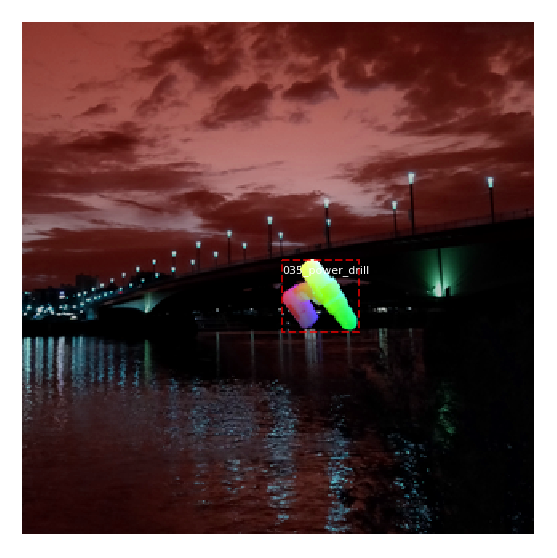

In [6]:
img_path = '/home/incendio/Desktop/inference_results/for_10k_data/power_drill_training/160_overfit/image.png'

def prepare_results(path, data, is_gt=True):
    img = cv2.imread(path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    box = np.array(data['rois'])
    class_id = np.array(data['class_ids'])
    if is_gt:
        r_mask = np.array(data['gt_r_masks'])
        g_mask = np.array(data['gt_g_masks'])
        b_mask = np.array(data['gt_b_masks'])
    else:
        r_masks = np.array(r['r_masks'])
        g_masks = np.array(r['g_masks'])
        b_masks = np.array(r['b_masks'])
    r_mask = (r_mask * 255).astype(np.uint8)
    g_mask = (g_mask * 255).astype(np.uint8)
    b_mask = (b_mask * 255).astype(np.uint8)
    masks = []
    for i in range(r_mask.shape[-1]):
        mask = np.stack([r_mask[:, :, i], g_mask[:, :, i], b_mask[:, :, i]], axis=2)
        masks.append(mask)
    masks = np.stack(masks, axis=2)
    masks = np.reshape(masks, (320, 320, 3*1))
    return image, box, class_id, masks
    
class_names = ['background', '002_master_chef_can', '003_cracker_box',
               '004_sugar_box', '005_tomato_soup_can', '006_mustard_bottle',
               '007_tuna_fish_can', '008_pudding_box', '009_gelatin_box',
               '010_potted_meat_can', '011_banana', '019_pitcher_base',
               '021_bleach_cleanser', '024_bowl',
               '025_mug', '035_power_drill',
               '036_wood_block', '037_scissors',
               '040_large_marker', '051_large_clamp',
               '052_extra_large_clamp', '061_foam_brick']
image, gt_box, gt_class_id, gt_masks = prepare_results(img_path, ground_truth)
print(gt_class_id)
visualize.display_rgb_instances(image, gt_box, gt_masks, gt_class_id, class_names, show_bbox=True, figsize=(10, 10))

[15]


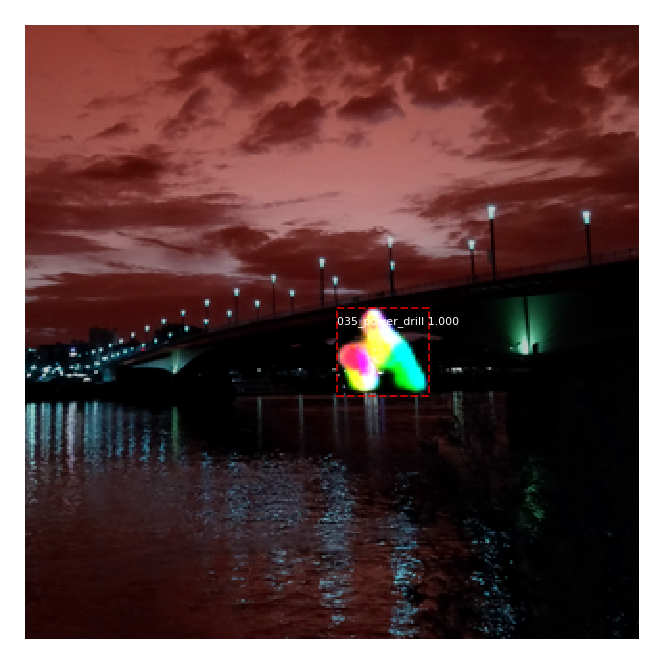

In [7]:
r = results
rois = np.array(r['rois'])
class_ids = np.array(r['class_ids'])
N = len(class_ids)

r_masks = np.array(r['r_masks'])
g_masks = np.array(r['g_masks'])
b_masks = np.array(r['b_masks'])

r_masks = (r_masks * 255).astype(np.uint8)
g_masks = (g_masks * 255).astype(np.uint8)
b_masks = (b_masks * 255).astype(np.uint8)
masks = []
for i in range(r_masks.shape[-1]):
    masks.append(np.stack([r_masks[:, :, i], g_masks[:, :, i], b_masks[:, :, i]], axis=2))
masks = np.stack(masks)
print(class_ids)
visualize.display_test_instances(image, rois, masks, class_ids, class_names, results['scores'], show_bbox=True, figsize=(12, 12))